<a href="https://colab.research.google.com/github/Angeruizo/Modelopreprocesamiento/blob/main/Tesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# 1. Montar Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Primeras filas del DataFrame:
   patient_id   image_idx gender  gestational_age  age(day)  weight  \
0           3  0003-1.jpg      F               40       5.2    3280   
1           3  0003-2.jpg      F               40       5.2    3280   
2           3  0003-3.jpg      F               40       5.2    3280   
3          35  0035-1.jpg      M               39       8.7    3760   
4          35  0035-2.jpg      M               39       8.7    3760   

   blood(mg/dL)  Treatment         label    filename  
0           3.9          0  no_ictericia  0003-1.jpg  
1           3.9          0  no_ictericia  0003-2.jpg  
2           3.9          0  no_ictericia  0003-3.jpg  
3          12.2          0  no_ictericia  0035-1.jpg  
4          12.2          0  no_ictericia  0035-2.jpg  

Cantidad de imágenes por clase:
label
no_ictericia    1302
ictericia        933
Name: count, dtype: int64


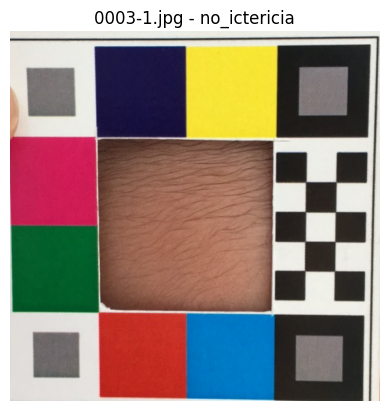

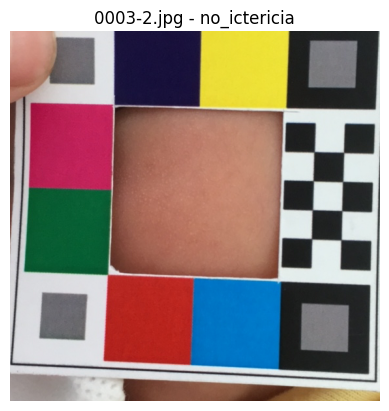

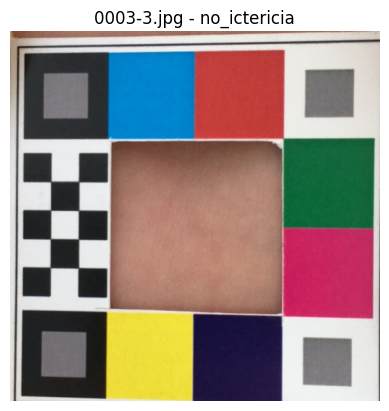

In [10]:
# 2. Leer imágenes + CSV
import pandas as pd
import os
import cv2
import numpy as np

ruta_csv = "/content/drive/MyDrive/Colab_Notebooks/Dataset_Tesis/chd_jaundice_published_2.csv"
ruta_imagenes = "/content/drive/MyDrive/Colab_Notebooks/Dataset_Tesis/images"

df = pd.read_csv(ruta_csv)
df["label"] = df["Treatment"].map({0: "no_ictericia", 1: "ictericia"})
df["filename"] = df["image_idx"]

# Mostrar primeras filas
print("Primeras filas del DataFrame:")
print(df.head())

# Mostrar cuántas imágenes hay por clase
print("\nCantidad de imágenes por clase:")
print(df["label"].value_counts())

# Probar abrir y mostrar las primeras 3 imágenes
for i in range(3):
    nombre_img = df.loc[i, "filename"]
    ruta_img = os.path.join(ruta_imagenes, nombre_img)

    if os.path.exists(ruta_img):
        img = cv2.imread(ruta_img)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(f"{nombre_img} - {df.loc[i, 'label']}")
        plt.axis("off")
        plt.show()
    else:
        print(f"Imagen no encontrada: {ruta_img}")


In [11]:
# 3. Preprocesamiento paso a paso con OpenCV

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def gray_world(img_bgr: np.ndarray) -> np.ndarray:
    b,g,r = cv.split(img_bgr.astype(np.float32))
    mb,mg,mr = b.mean()+1e-6, g.mean()+1e-6, r.mean()+1e-6
    m  = (mb+mg+mr)/3.0
    kb,kg,kr = m/mb, m/mg, m/mr
    out = cv.merge([np.clip(b*kb,0,255), np.clip(g*kg,0,255), np.clip(r*kr,0,255)]).astype(np.uint8)
    return out

def clahe_on_L(img_bgr: np.ndarray, clip=2.0, tiles=(8,8)) -> np.ndarray:
    lab = cv.cvtColor(img_bgr, cv.COLOR_BGR2LAB)
    L,a,b = cv.split(lab)
    clahe = cv.createCLAHE(clipLimit=clip, tileGridSize=tiles)
    L = clahe.apply(L)
    lab = cv.merge([L,a,b])
    return cv.cvtColor(lab, cv.COLOR_LAB2BGR)

def preprocess_color(img_bgr: np.ndarray) -> np.ndarray:
    img = gray_world(img_bgr)
    img = clahe_on_L(img, clip=2.0, tiles=(8,8))  # mejora contraste en sombras sin “quemar” colores
    return img

In [29]:
# 3.1 Segmentación (piel → amarillo en HSV)

# 3.1.a) Máscara de piel robusta (YCrCb ∩ HSV) + exclusión del checker
def mask_skin_better(img_bgr: np.ndarray) -> np.ndarray:
    # YCrCb (piel)
    ycrcb = cv.cvtColor(img_bgr, cv.COLOR_BGR2YCrCb)
    lower_ycrcb = np.array([0, 133, 77], np.uint8)
    upper_ycrcb = np.array([255, 173, 127], np.uint8)
    m1 = cv.inRange(ycrcb, lower_ycrcb, upper_ycrcb)

    # HSV (piel cálida, evitando rojos puros)
    hsv = cv.cvtColor(img_bgr, cv.COLOR_BGR2HSV)
    lower_hsv = np.array([0, 20, 50], np.uint8)
    upper_hsv = np.array([25, 220, 255], np.uint8)
    m2 = cv.inRange(hsv, lower_hsv, upper_hsv)

    mask = cv.bitwise_and(m1, m2)

    # Excluir colores típicos de checker y objetos saturados
    excl  = cv.inRange(hsv, (95,40,40),  (130,255,255))   # azul
    excl |= cv.inRange(hsv, (0,40,40),   (10,255,255))    # rojo 1
    excl |= cv.inRange(hsv, (170,40,40), (180,255,255))   # rojo 2
    excl |= cv.inRange(hsv, (35,40,40),  (90,255,255))    # verde
    excl |= cv.inRange(hsv, (135,40,40), (165,255,255))   # magenta
    excl |= cv.inRange(hsv, (20,90,90),  (40,255,255))    # amarillo saturado
    excl |= cv.inRange(hsv, (0,0,210),   (180,30,255))    # blanco brillante
    excl |= cv.inRange(hsv, (0,0,0),     (180,255,50))    # negro

    mask = cv.bitwise_and(mask, cv.bitwise_not(excl))

    # Morfología
    k = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7,7))
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN,  k, iterations=2)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, k, iterations=2)

    # Mantener componente principal
    num, labels, stats, _ = cv.connectedComponentsWithStats(mask, 8)
    if num > 1:
        h, w = mask.shape
        cx, cy = w // 2, h // 2
        best, best_score = 0, -1

        for i in range(1, num):
            x, y, ww, hh, area = stats[i]
            if area < 800:
                continue

            # Excluir si es muy cuadrado y en borde → checker probable
            aspect_ratio = ww / float(hh + 1e-6)
            if 0.9 <= aspect_ratio <= 1.1:
                if (x < 20 or y < 20 or x+ww > w-20 or y+hh > h-20):
                    continue

            # Bordes muy marcados → checker probable
            roi_gray = cv.cvtColor(img_bgr[y:y+hh, x:x+ww], cv.COLOR_BGR2GRAY)
            edges = cv.Canny(roi_gray, 100, 200)
            edge_density = edges.sum() / 255.0 / (ww * hh)
            if edge_density > 0.15:
                continue

            # Dispersión alta de tono → checker probable
            roi_hsv = cv.cvtColor(img_bgr[y:y+hh, x:x+ww], cv.COLOR_BGR2HSV)
            hue_std = roi_hsv[..., 0].std()
            if hue_std > 25:
                continue

            # Calcular score por área y cercanía al centro
            dx, dy = (x + ww / 2) - cx, (y + hh / 2) - cy
            score = area / (np.hypot(dx, dy) + 1e-3)
            if score > best_score:
                best, best_score = i, score

        mask = np.uint8(labels == best) * 255

    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, k, iterations=2)

    # === Filtrar por sector central estimado (ROI) ===
    h, w = mask.shape
    roi_x1 = int(w * 0.25)
    roi_x2 = int(w * 0.75)
    roi_y1 = int(h * 0.25)
    roi_y2 = int(h * 0.75)

    roi_mask = np.zeros_like(mask)
    roi_mask[roi_y1:roi_y2, roi_x1:roi_x2] = 255

    mask = cv.bitwise_and(mask, roi_mask)

    return mask





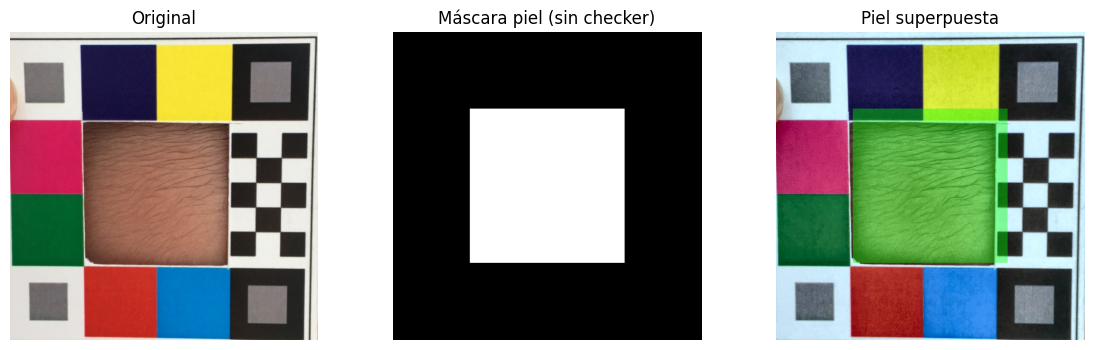

In [30]:
# === Test rápido de 3.1.a ===

import os

def find_existing_path(base_dir, fname):
    candidates = [fname, f"{fname}.jpg", f"{fname}.png", f"{fname}.jpeg", f"{fname}.JPG"]
    for c in candidates:
        p = os.path.join(base_dir, c)
        if os.path.exists(p):
            return p
    return None

# 1) Seleccionar índice de imagen para prueba
i = 0  # cambia para probar otra imagen
fname = df.loc[i, "filename"]
path = find_existing_path(ruta_imagenes, fname)
assert path is not None, f"No encontré la imagen: {fname}"

# 2) Cargar y preprocesar
bgr0 = cv.imread(path); assert bgr0 is not None, path
bgr  = preprocess_color(bgr0)

# 3) Generar máscara de piel con eliminación de checker
skin_mask = mask_skin_better(bgr)

# 4) Visualizar resultados
plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.imshow(cv.cvtColor(bgr0, cv.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(skin_mask, cmap="gray"); plt.title("Máscara piel (sin checker)"); plt.axis("off")

# Superponer máscara sobre imagen
overlay = bgr.copy()
overlay[skin_mask>0] = (0,255,0)
blend = cv.addWeighted(bgr, 0.6, overlay, 0.4, 0)
plt.subplot(1,3,3); plt.imshow(cv.cvtColor(blend, cv.COLOR_BGR2RGB)); plt.title("Piel superpuesta"); plt.axis("off")

plt.show()


In [21]:
# 3.1.b) BGR → HSV y máscara de amarillo adaptativa dentro de la piel

def yellow_mask_adaptive(img_bgr: np.ndarray, skin_mask: np.ndarray) -> np.ndarray:
    hsv = cv.cvtColor(img_bgr, cv.COLOR_BGR2HSV)
    H,S,V = cv.split(hsv)

    # Percentiles dentro de piel (ignora fondo y checker)
    s_vals = S[skin_mask>0].astype(np.float32)
    v_vals = V[skin_mask>0].astype(np.float32)
    if len(s_vals) == 0 or len(v_vals) == 0:
        return np.zeros_like(skin_mask)

    s_min = int(max(40, np.percentile(s_vals, 35)))  # 35º pctl: sube en fotos brillantes, baja en oscuras
    v_min = int(max(60, np.percentile(v_vals, 30)))

    lower = np.array([15, s_min, v_min], np.uint8)
    upper = np.array([35, 255, 255],    np.uint8)

    base_mask = cv.inRange(hsv, lower, upper)

    # Restringir a piel y limpiar
    mask = cv.bitwise_and(base_mask, skin_mask)
    k = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN,  k, iterations=1)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, k, iterations=2)

    # Quitar regiones muy pequeñas
    num, labels, stats, _ = cv.connectedComponentsWithStats(mask, 8)
    keep = np.zeros_like(mask)
    for i in range(1, num):
        if stats[i, cv.CC_STAT_AREA] >= 300:  # ⚙️ ajusta según resolución
            keep[labels==i] = 255
    return keep

In [22]:
# 3.1.c) Función de vista previa (original / piel / amarillo superpuesto)

def preview_yellow(path):
    bgr0 = cv.imread(path); assert bgr0 is not None, path
    bgr  = preprocess_color(bgr0)

    skin = mask_skin_better(bgr)
    yel  = yellow_mask_adaptive(bgr, skin)

    # Overlays
    over_skin = bgr.copy();  over_skin[skin>0] = (0,255,0)
    over_yel  = bgr.copy();  over_yel[yel>0]  = (0,255,255)
    blend_s = cv.addWeighted(bgr, 0.6, over_skin, 0.4, 0)
    blend_y = cv.addWeighted(bgr, 0.6, over_yel,  0.4, 0)

    # Mostrar en RGB
    def toRGB(x): return cv.cvtColor(x, cv.COLOR_BGR2RGB)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(toRGB(bgr0)); plt.title('Original'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(toRGB(blend_s)); plt.title('Piel (máscara)'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(toRGB(blend_y)); plt.title('Amarillo (HSV adaptativo)'); plt.axis('off')
    plt.show()